In [1]:
library(data.table)
library(dplyr)
library(redeemR)
library(stringr)
library(BuenColors)
library(ggtree)
library(ape)
library(phangorn)
library(ggtreeExtra)
source('00_functions.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“replacing previous import ‘ape::where’ by ‘dplyr::where’ when loading ‘redeemR’”
Warning message:
“replacing previous import ‘ape::keep.tip’ by ‘tidytree::keep.tip’ when loading ‘redeemR’”
Warning message:
“replacing previous import ‘ape::drop.tip’ by ‘tidytree::drop.tip’ when loading ‘redeemR’”
Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: ggplot2

ggtree v3.12.0 For help: https://yulab-smu.top/treedata-book/

If you use the ggtree package suite in published research, please cite
the appropriate paper(s):

Guangchuang Yu, David Smith, Huachen Zhu, Yi Guan, Tommy Tsan-Yuk Lam.
g

In [71]:
# Example
# sample_id = "Old2.BMMC"
sample_id = "Young1.T1.BMMC"
base_dir = '/Users/tgao/redeem/'

# Import data
redeemV_data <- fread(paste0(base_dir,sample_id,".Consensus.final/RawGenotypes.Sensitive.StrandBalance"))
mgatk_df_in <- fread(paste0("../data/mgatk-varstats/D_",sample_id,"_hg38_v20-mtMask.variant_stats.tsv.gz"))
mgatk_df <- mgatk_df_in %>% filter(strand_correlation > 0.65 & n_cells_conf_detected >= 3 & (log10(vmr) > -2) & mean < 0.9) %>%
mutate(redeem_formatted = paste0(position, "_", gsub(">", "_", nucleotide)))
mgatk_vars <- mgatk_df %>% arrange(desc(n_cells_conf_detected)) %>% 
pull(redeem_formatted) 
very_high <- mgatk_df %>% filter(mean> 0.4) %>% pull(redeem_formatted)
print("some variants were very high...")
print(mgatk_df %>% filter(mean> 0.4))
print(" ")

[1] "some variants were very high..."
   position nucleotide variant        vmr      mean   variance
      <int>     <char>  <char>      <num>     <num>      <num>
1:      194        C>T  194C>T 0.04900644 0.8653179 0.04240615
2:      310        T>C  310T>C 0.03127789 0.8080778 0.02527497
   n_cells_conf_detected n_cells_over_5 n_cells_over_10 n_cells_over_20
                   <int>          <int>           <int>           <int>
1:                    63            693             693             691
2:                  4511           5170            5168            5154
   n_cells_over_95 max_heteroplasmy strand_correlation mean_coverage
             <int>            <num>              <num>         <num>
1:             686                1              0.767     0.3332691
2:            1034                1              0.904    19.0260065
   redeem_formatted
             <char>
1:          194_C_T
2:          310_T_C
[1] " "


In [72]:
homoplasmic_vars <- mgatk_df_in %>% arrange(desc(n_cells_conf_detected)) %>%
    filter(mean > 0.9) %>%
    mutate(redeem_formatted = paste0(position, "_", gsub(">", "_", nucleotide))) %>%
    pull(redeem_formatted)

In [73]:
# Load scatters
redeem_df <- fread(paste0("../data/redeem-sensitive-calls/",sample_id,".Consensus.final_S.tsv"))

# Define thresholds of suspicous variants
threshold_avg <- 1.3
threshold_cells <- 20

In [74]:
sens_df_annotated <- redeem_df %>%
    filter(!c(Variants %in% bad_vars_cw) & !c(Variants %in% very_high)) %>%
    mutate(avg_support_per_pos_cell = TotalVcount/CellN) %>%
    mutate(color = case_when(Variants %in% mgatk_vars ~ "mgatkcall",
                             CellN > threshold_cells & avg_support_per_pos_cell < threshold_avg  ~ "redeemProblem",
                             TRUE ~ "redeemOK"))

In [75]:
mgatk_overlap_problem <- sens_df_annotated %>% filter(CellN > threshold_cells & color == "mgatkcall" & avg_support_per_pos_cell < threshold_avg)
all_problems <- sens_df_annotated %>% filter(CellN > threshold_cells & avg_support_per_pos_cell < threshold_avg) %>% dim()
print("variants that mgatk called that we are claiming are problematic")
print(mgatk_overlap_problem)

print("other problematic variants")
print(all_problems)

[1] "variants that mgatk called that we are claiming are problematic"
    Variants CellN PositiveMean maxcts   CellNPCT TotalVcount TotalCov
      <char> <int>        <num>  <int>      <num>       <int>    <num>
1: 15785_T_C   101    0.0310648      2 0.01675236         109   232942
       totalVAF       CV HomoTag avg_support_per_pos_cell     color
          <num>    <num>  <char>                    <num>    <char>
1: 0.0004679277 0.107916  Hetero                 1.079208 mgatkcall
[1] "other problematic variants"
[1] 296  12


In [76]:
sens_df_annotated %>% 
    mutate(variant_alias = paste0('Variants', str_remove_all(Variants, '_'))) %>%
    fwrite(paste0('../data/', sample_id, '.var.annot.csv'))

In [36]:
df_pos = redeemV_data %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemProblem") %>% pull(Variants))) %>%
    make_position_df()

In [80]:
df_pos_ok = redeemV_data %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemOK") %>% pull(Variants))) %>%
    make_position_df()

In [82]:
df_pos_ok %>% make_ks_test_df %>% count(statistic > 0.35)

Warning message:
“There were 1046 warnings in `mutate()`.
The first warning was:
ℹ In argument: `D_stat = map(data, ~(ks.test(.x$rel_position, "punif", 0, 1)))`.
Caused by warning in `ks.test.default()`:
! ties should not be present for the one-sample Kolmogorov-Smirnov test
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1045 remaining warnings.”


statistic > 0.35,n
<lgl>,<int>
FALSE,2321
TRUE,1119


In [83]:
1119/(1119 + 2321)

[1] 0.3252907

In [59]:
df_pos %>% make_ks_test_df %>% count(statistic > 0.35)

Warning message:
“There were 410 warnings in `mutate()`.
The first warning was:
ℹ In argument: `D_stat = map(data, ~(ks.test(.x$rel_position, "punif", 0, 1)))`.
Caused by warning in `ks.test.default()`:
! ties should not be present for the one-sample Kolmogorov-Smirnov test
ℹ Run `dplyr::last_dplyr_warnings()` to see the 409 remaining warnings.”


statistic > 0.35,n
<lgl>,<int>
FALSE,133
TRUE,312


In [56]:
vars_fail = df_pos %>% make_ks_test_df %>% filter(statistic > 0.35) %>% pull(variant)

Warning message:
“There were 410 warnings in `mutate()`.
The first warning was:
ℹ In argument: `D_stat = map(data, ~(ks.test(.x$rel_position, "punif", 0, 1)))`.
Caused by warning in `ks.test.default()`:
! ties should not be present for the one-sample Kolmogorov-Smirnov test
ℹ Run `dplyr::last_dplyr_warnings()` to see the 409 remaining warnings.”


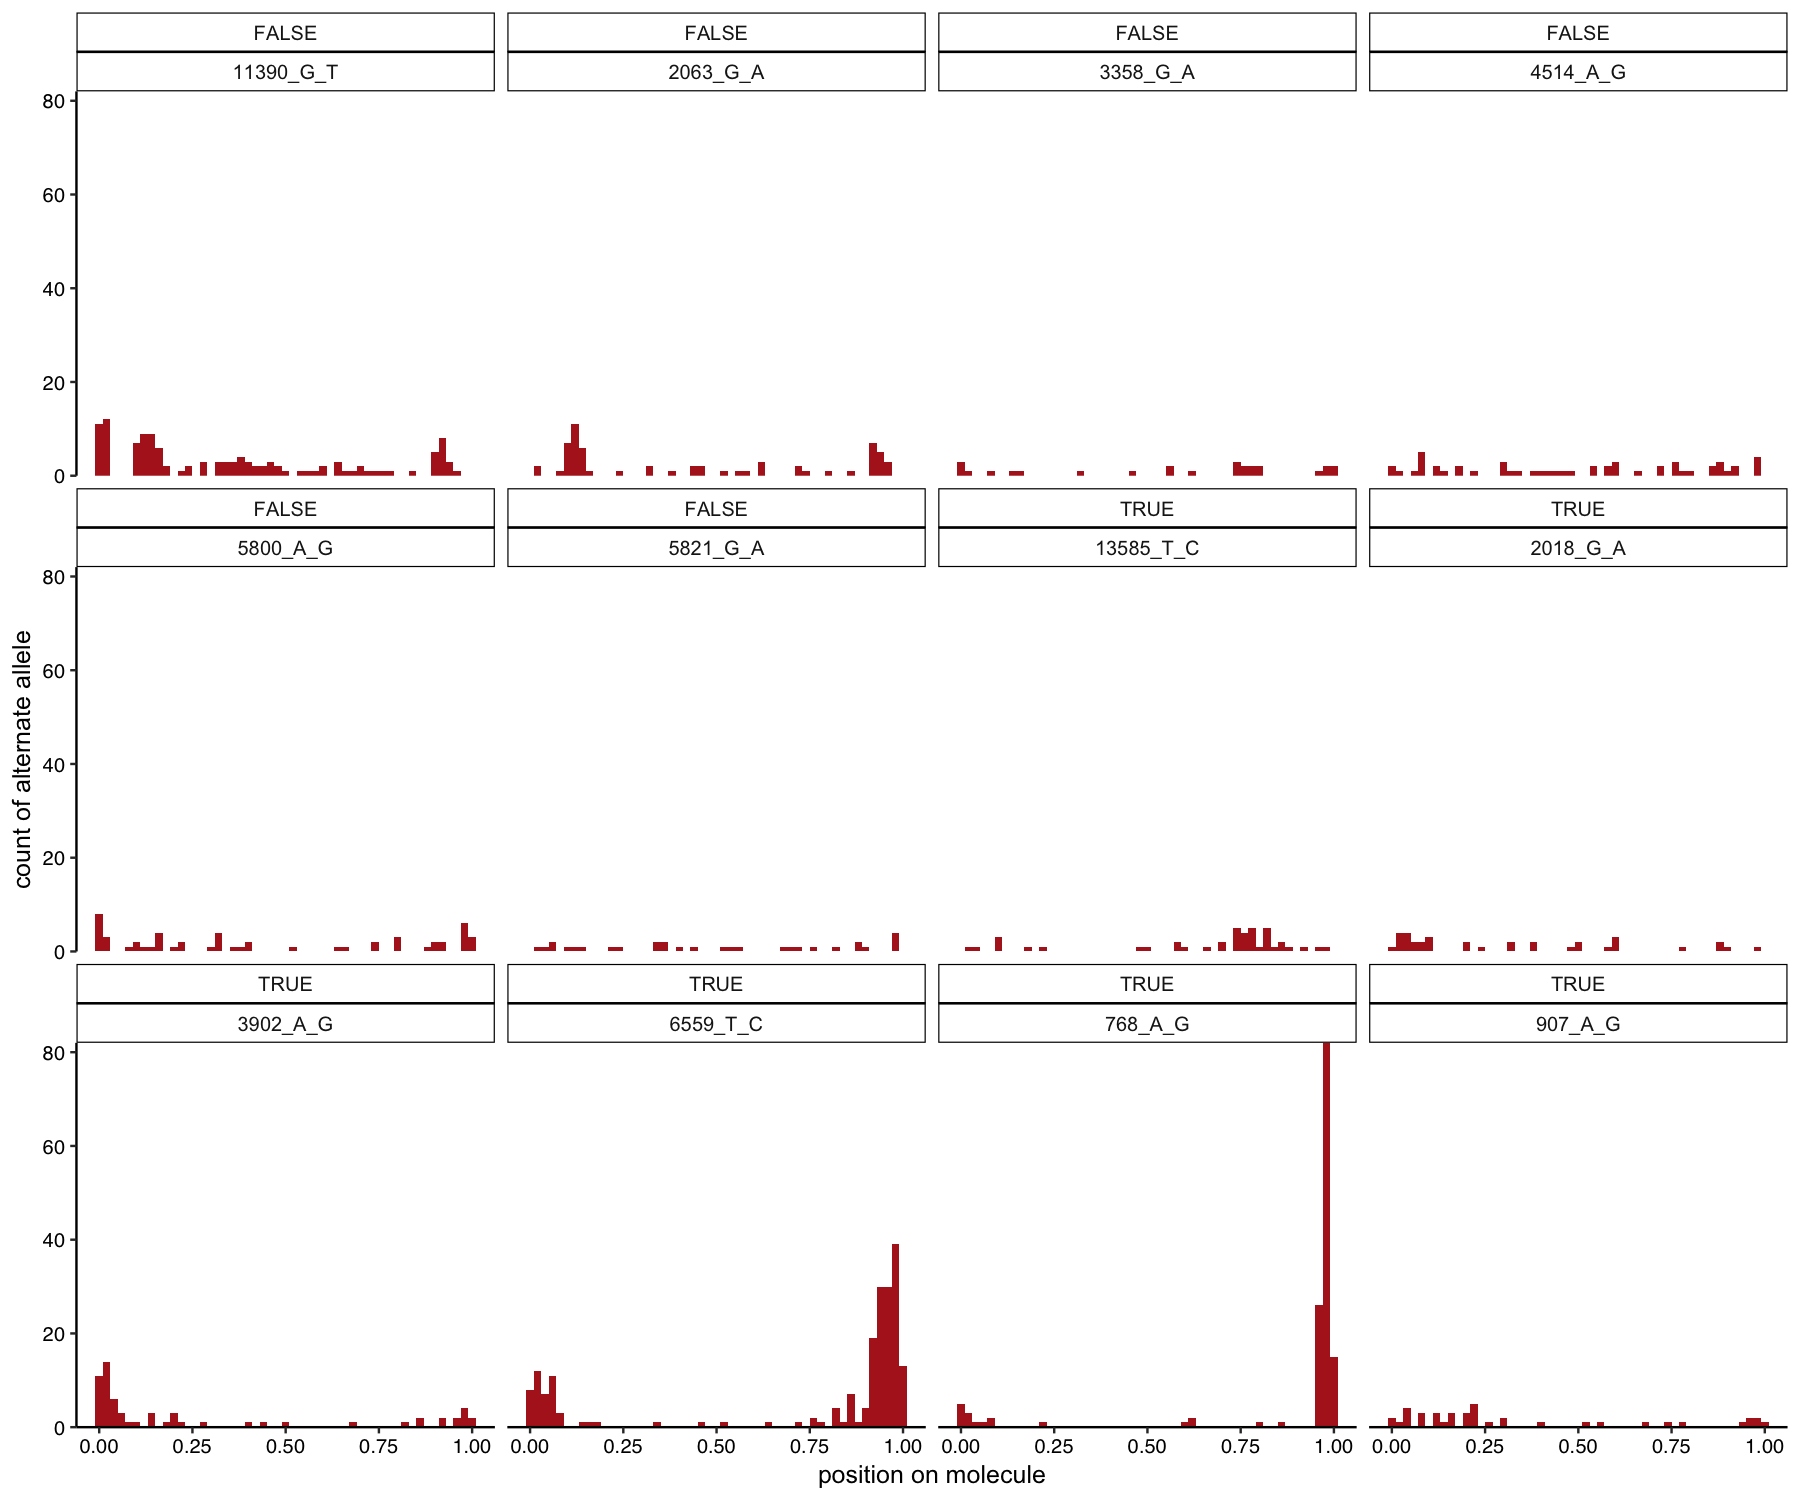

In [58]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 300)

df_pos %>% 
filter(variant %in% sample(unique(variant), 12)) %>%
mutate(ks.fail = variant %in% vars_fail) %>%
ggplot(aes(x = rel_position)) + 
    geom_histogram(bins = 51, fill = "firebrick") + scale_y_continuous(expand = c(0,0)) + 
    labs(x = "position on molecule", y = "count of alternate allele") + pretty_plot(fontsize = 6) + L_border() +
    facet_wrap(~ks.fail+variant)

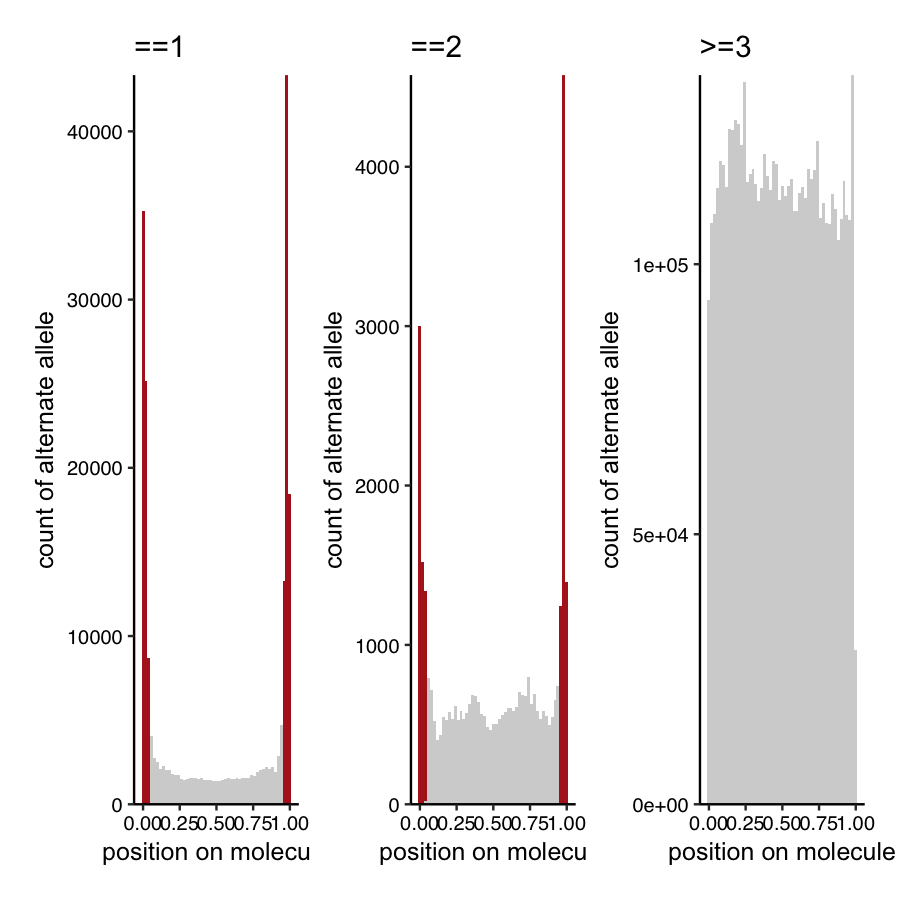

In [93]:
redeemV_data$count <- redeemV_data %>% group_by(V2, V4) %>% mutate(count = n()) %>% pull(count)
pos_df <- make_position_df(redeemV_data)
redeemV_data$rel_position <- pos_df$rel_position
redeemV_data$keep <-  (pos_df$rel_position >= 0.05 & pos_df$rel_position <= 0.95) | redeemV_data$count >= 3

make_plot <- function(df, title){
    df %>%
    ggplot(aes(x = rel_position, fill = keep)) + 
    geom_histogram(bins = 51) + scale_y_continuous(expand = c(0,0)) + 
    labs(x = "position on molecule", y = "count of alternate allele") + pretty_plot(fontsize = 6) + L_border() +
    ggtitle(title) + 
    scale_fill_manual(values = c("TRUE" = "lightgrey", "FALSE" = "firebrick")) + 
    theme(legend.position = "none")
}

p1 <- make_plot(redeemV_data %>% filter(count == 1) , "==1")
p2 <- make_plot(redeemV_data %>% filter(count == 2) , "==2")
p3 <- make_plot(redeemV_data %>% filter(count > 2) , ">=3")

In [100]:
redeemV_data %>% filter(count == 1) %>%
filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemProblem") %>% pull(Variants))) %>% dim

[1] 15960    17

In [105]:
p1 = redeemV_data %>% filter(count == 1) %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemOK") %>% pull(Variants))) %>% 
    make_plot("non-LMHC, ==1")

p2 = redeemV_data %>% filter(count == 2) %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemOK") %>% pull(Variants))) %>% 
    make_plot("non-LMHC, ==2")

p3 = redeemV_data %>% filter(count >= 3) %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemOK") %>% pull(Variants))) %>% 
    make_plot("non-LMHC, >=3")

p4 = redeemV_data %>% filter(count == 1) %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemProblem") %>% pull(Variants))) %>% 
    make_plot("LMHC, ==1")

p5 = redeemV_data %>% filter(count == 2) %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemProblem") %>% pull(Variants))) %>% 
    make_plot("LMHC, ==2")

p6 = redeemV_data %>% filter(count >= 3) %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemProblem") %>% pull(Variants))) %>% 
    make_plot("LMHC, >=3")

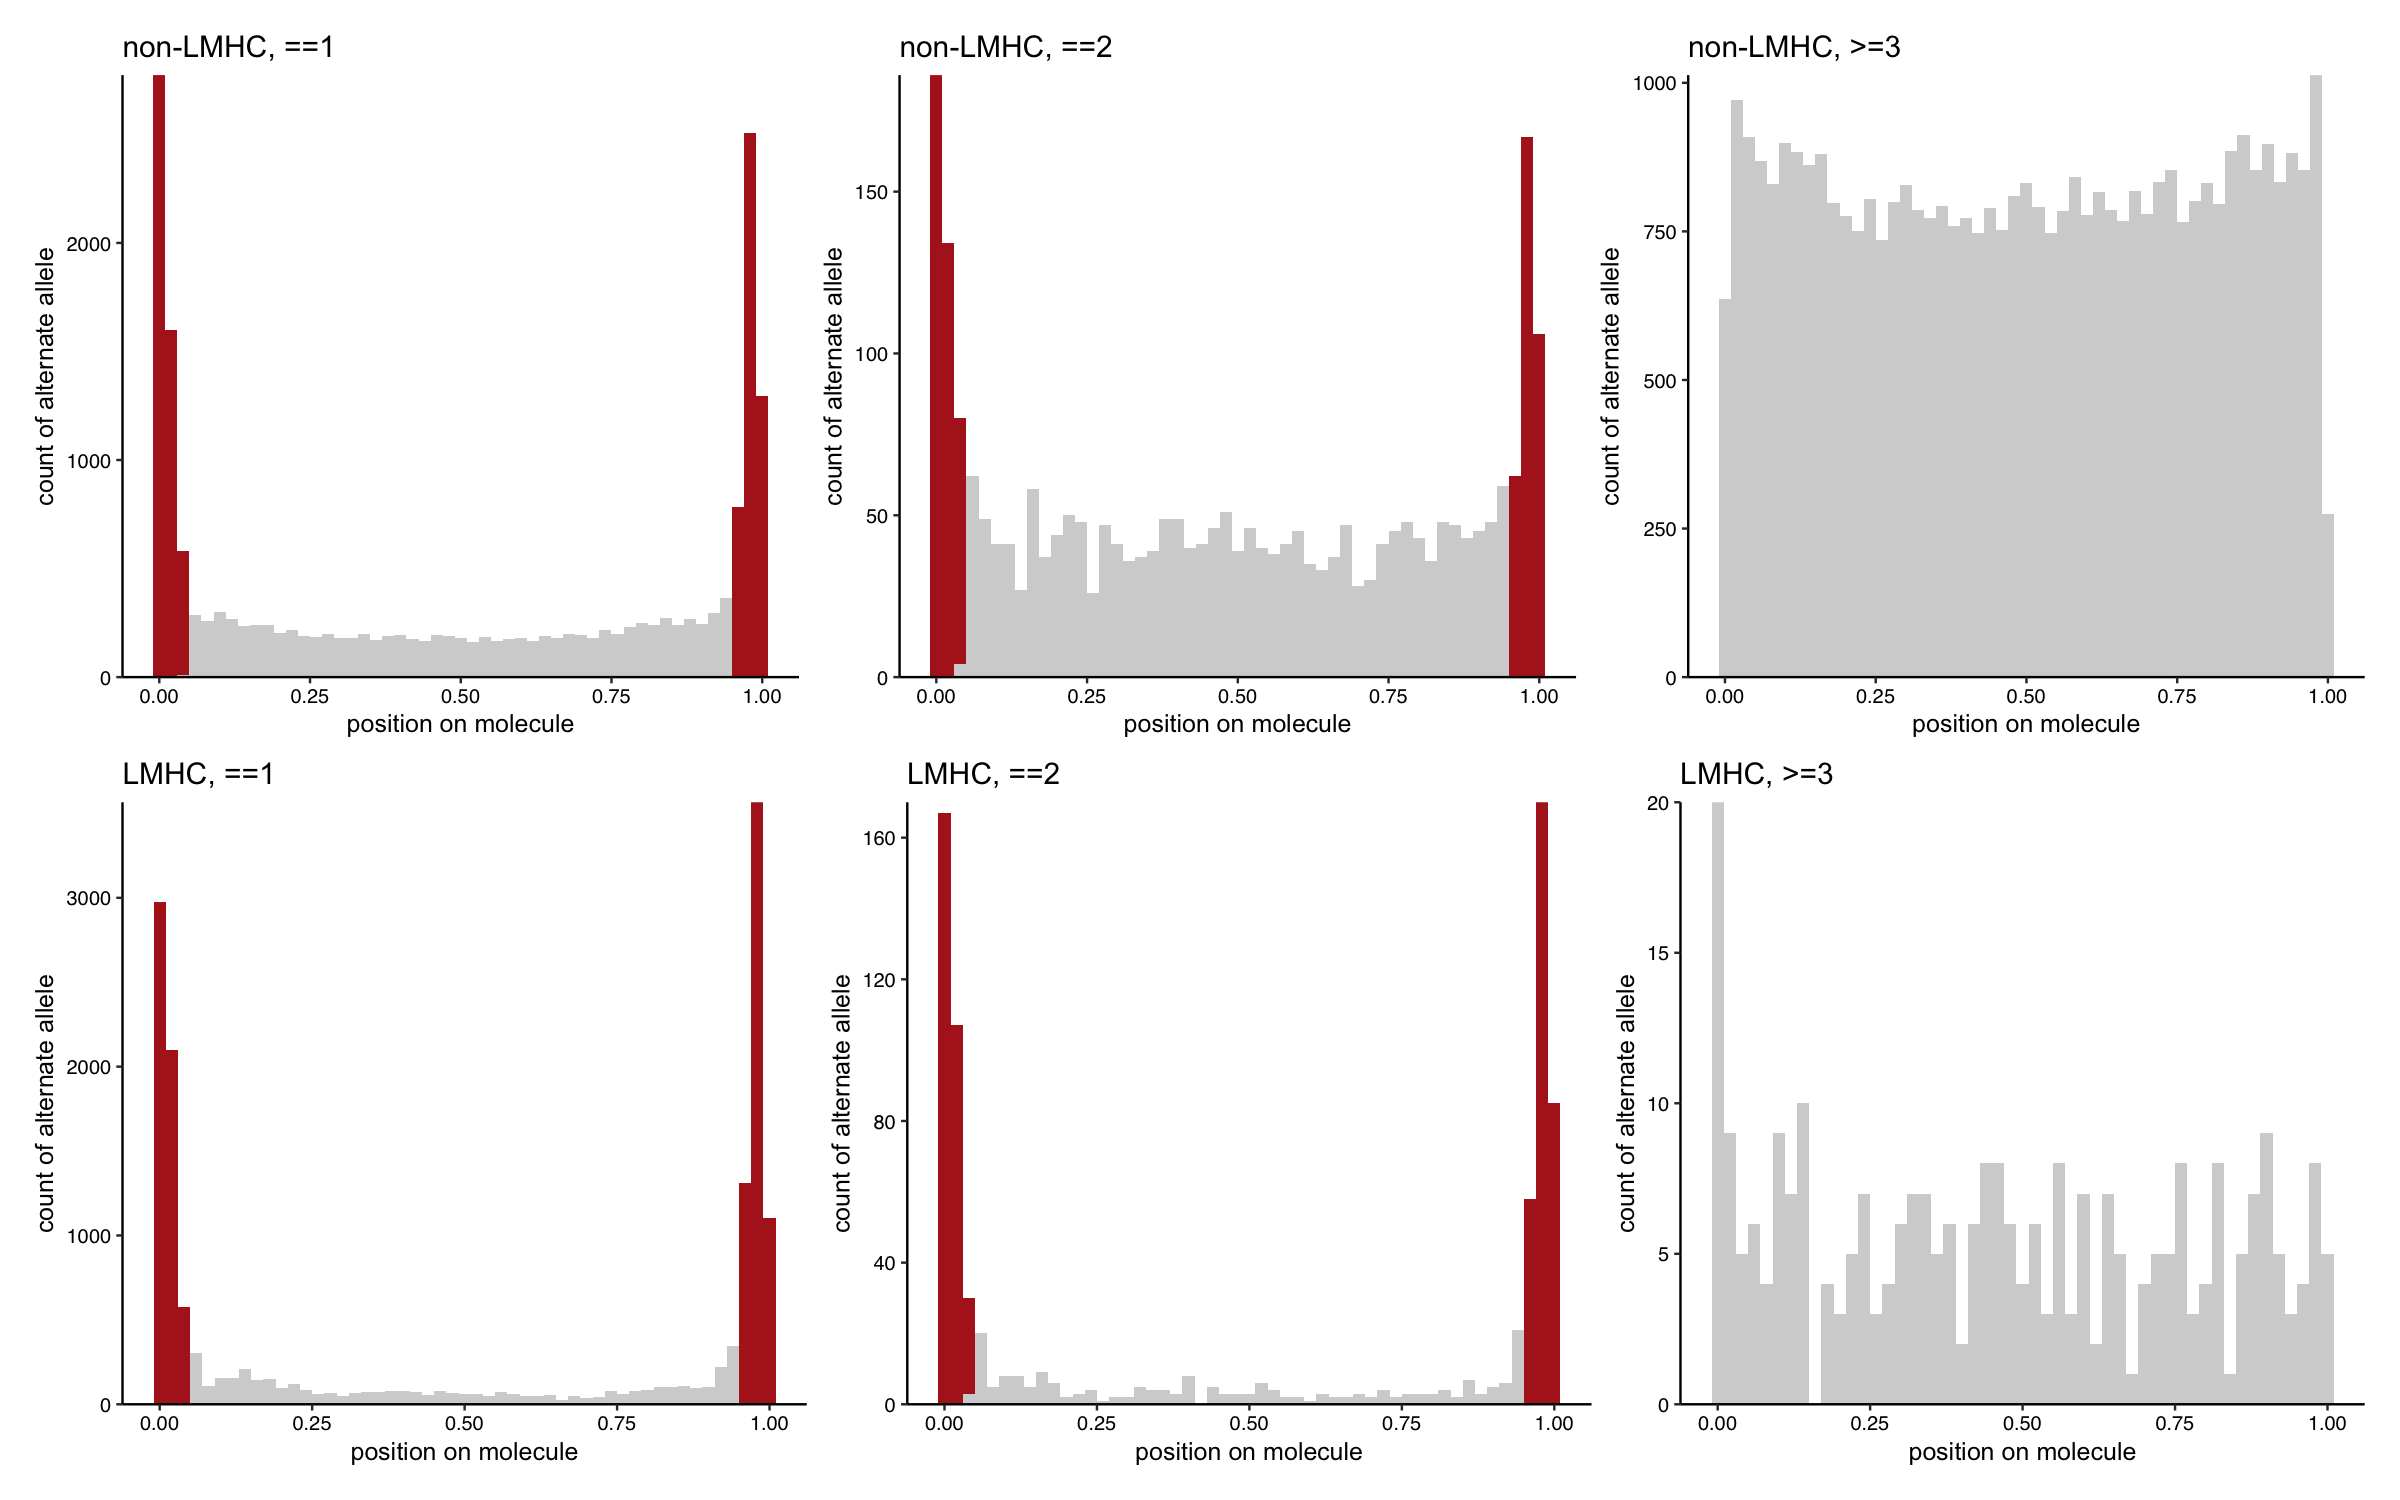

In [106]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)

(p1 | p2 | p3) / (p4 | p5 | p6)

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 2.5, repr.plot.res = 300)

p1 | p2 | p3

In [99]:
redeemV_data %>% filter(count == 1) %>%
filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemOK") %>% pull(Variants))) %>% dim

[1] 19167    17

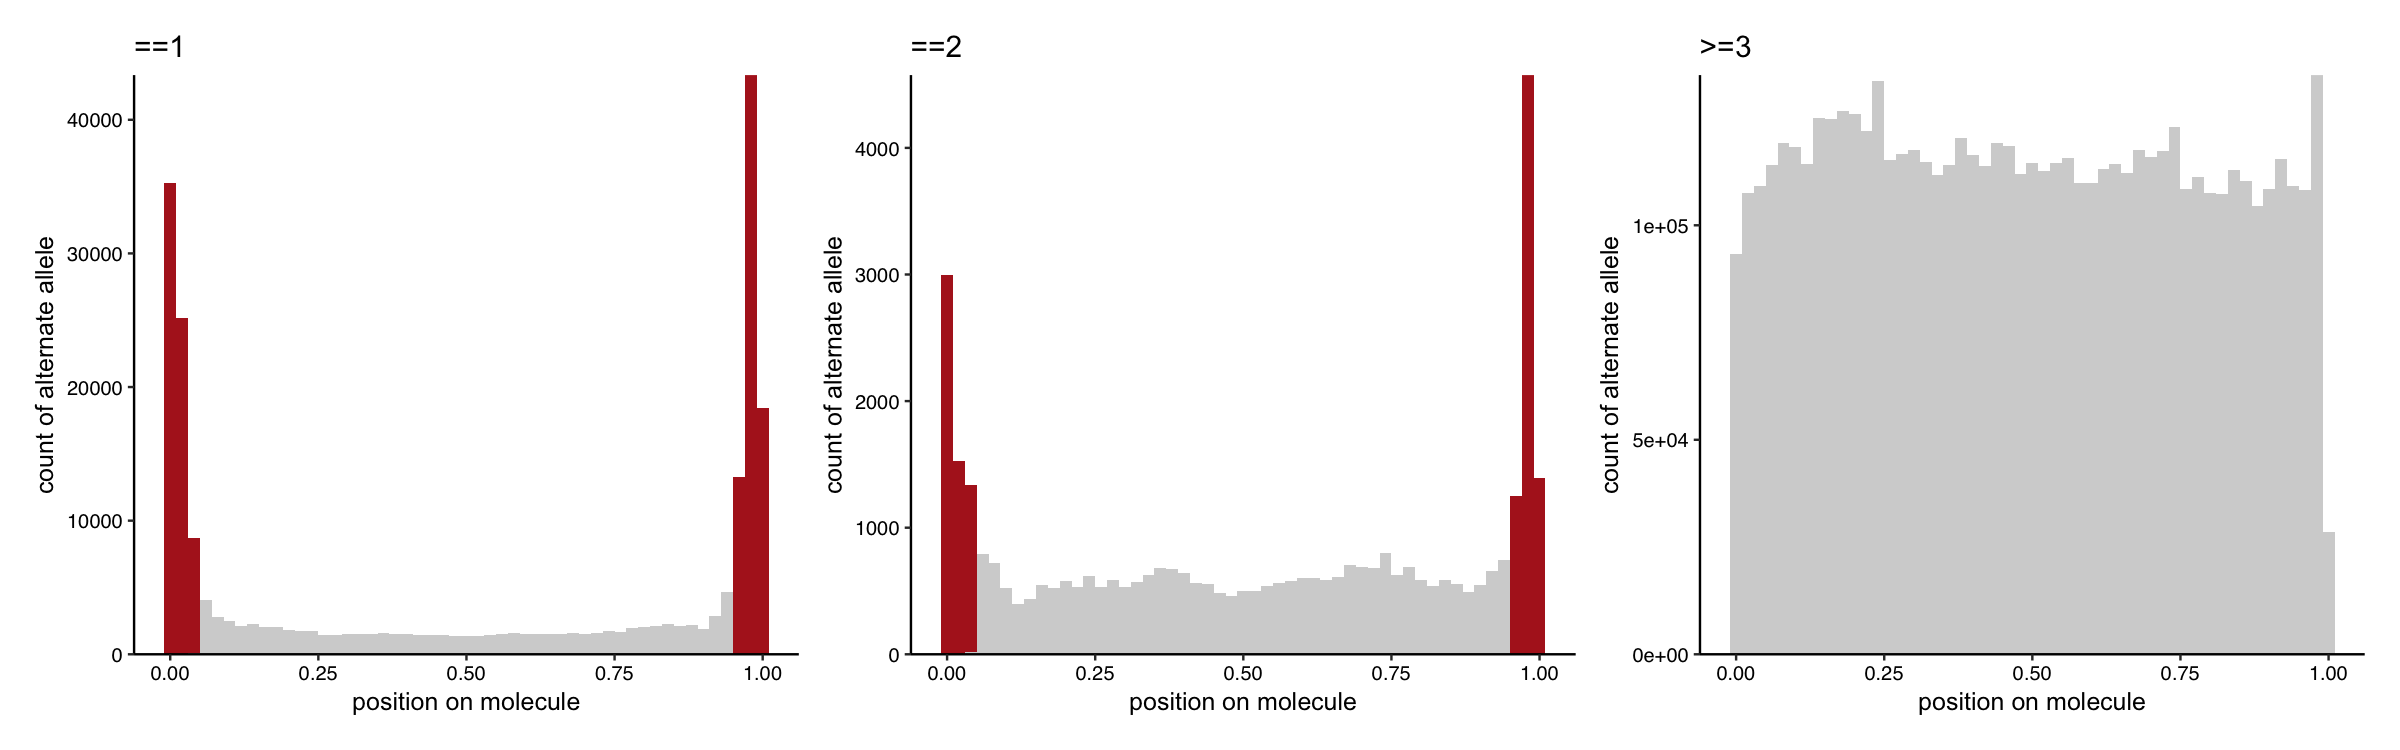

In [96]:
options(repr.plot.width = 8, repr.plot.height = 2.5, repr.plot.res = 300)

p1 | p2 | p3

In [15]:
p2 <- redeemV_data %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemProblem") %>% pull(Variants))) %>%
    make_position_df() %>%
    ggplot(aes(x = rel_position)) + 
    geom_histogram(bins = 51, fill = "firebrick") + scale_y_continuous(expand = c(0,0)) + 
    labs(x = "position on molecule", y = "count of alternate allele") + pretty_plot(fontsize = 6) + L_border()

p3 <- redeemV_data %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "mgatkcall") %>% pull(Variants))) %>%
    make_position_df() %>%
    ggplot(aes(x = rel_position)) + 
    geom_histogram(bins = 51, fill = "dodgerblue3") + scale_y_continuous(expand = c(0,0)) + 
    labs(x = "position on molecule", y = "count of alternate allele") + pretty_plot(fontsize = 6) + L_border()

#Make a profile of homoplasmic variants for control
p4 <- redeemV_data %>%
    filter(V4 %in% homoplasmic_vars) %>%
    make_position_df() %>%
    ggplot(aes(x = rel_position)) + scale_y_continuous(expand = c(0,0)) + 
    geom_histogram(bins = 51, fill = "darkgrey") +
    labs(x = "position on molecule", y = "count of alternate allele") + pretty_plot(fontsize = 6)+ L_border()

In [77]:
sens_df_annotated %>% count(color)

color,n
<chr>,<int>
mgatkcall,158
redeemOK,3440
redeemProblem,295


In [78]:
p5 <- redeemV_data %>%
    filter(V4 %in% (sens_df_annotated %>% filter(color == "redeemOK") %>% pull(Variants))) %>%
    make_position_df() %>%
    ggplot(aes(x = rel_position)) + scale_y_continuous(expand = c(0,0)) + 
    geom_histogram(bins = 51, fill = "darkgrey") +
    labs(x = "position on molecule", y = "count of alternate allele") + pretty_plot(fontsize = 6)+ L_border()

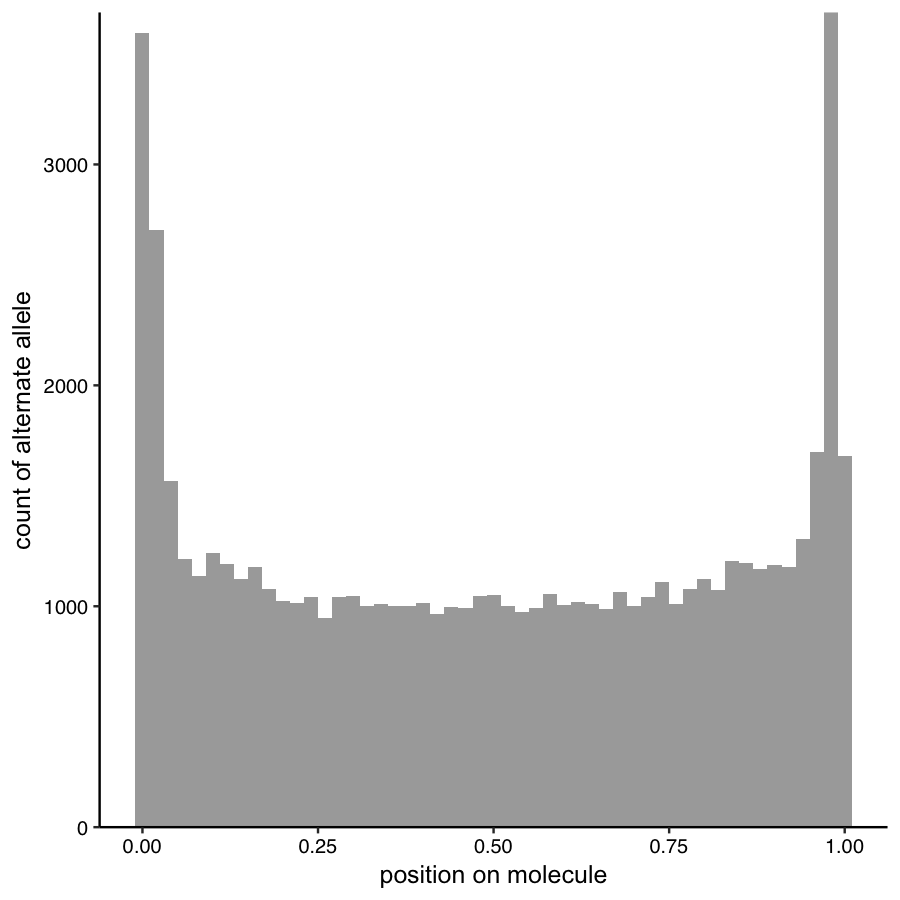

In [79]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 300)

p5

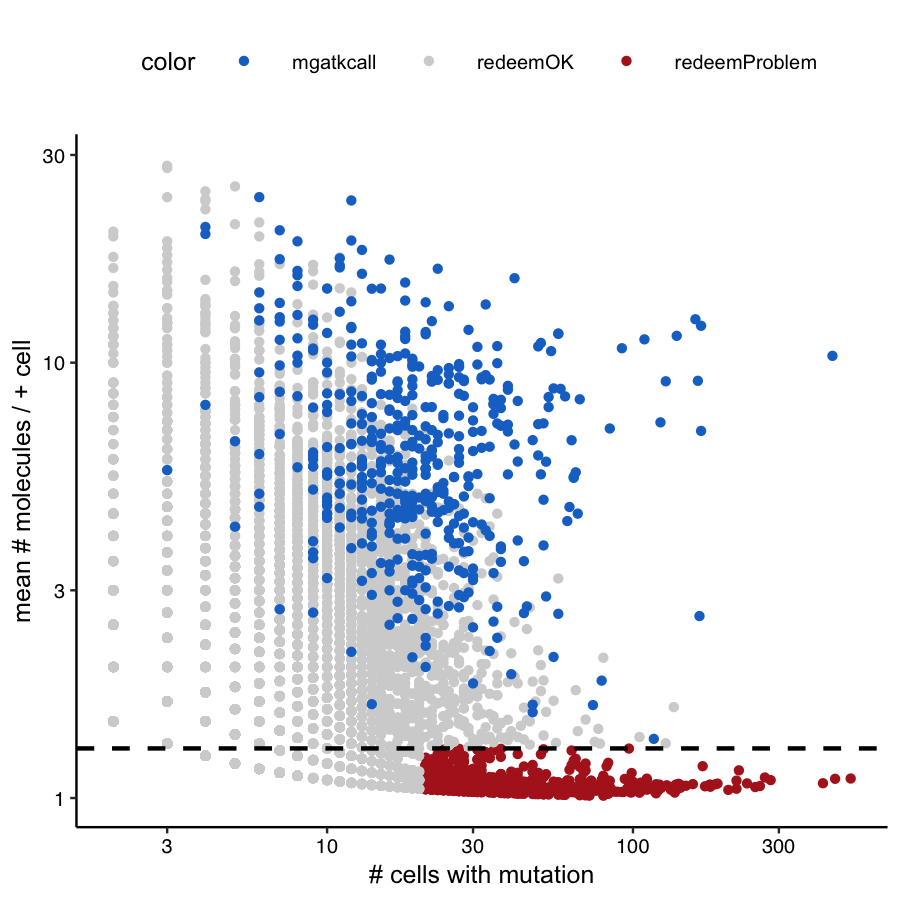

In [17]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 300)

p1 <- ggplot(sens_df_annotated %>% arrange(desc(color)), aes(x = CellN, y = avg_support_per_pos_cell, label = Variants, color = color)) +
    geom_point(size = 0.5) + scale_x_log10() + scale_y_log10() +
    geom_hline(yintercept = threshold_avg, linetype = 2) +
    pretty_plot(fontsize = 6) + labs(x = "# cells with mutation", y = "mean # molecules / + cell") +
    scale_color_manual(values = c("dodgerblue3", "lightgrey","firebrick")) +
    theme(legend.position = "top") + L_border()

p1

In [31]:
sens_df_annotated %>% count(color)

color,n
<chr>,<int>
mgatkcall,464
redeemOK,5360
redeemProblem,445


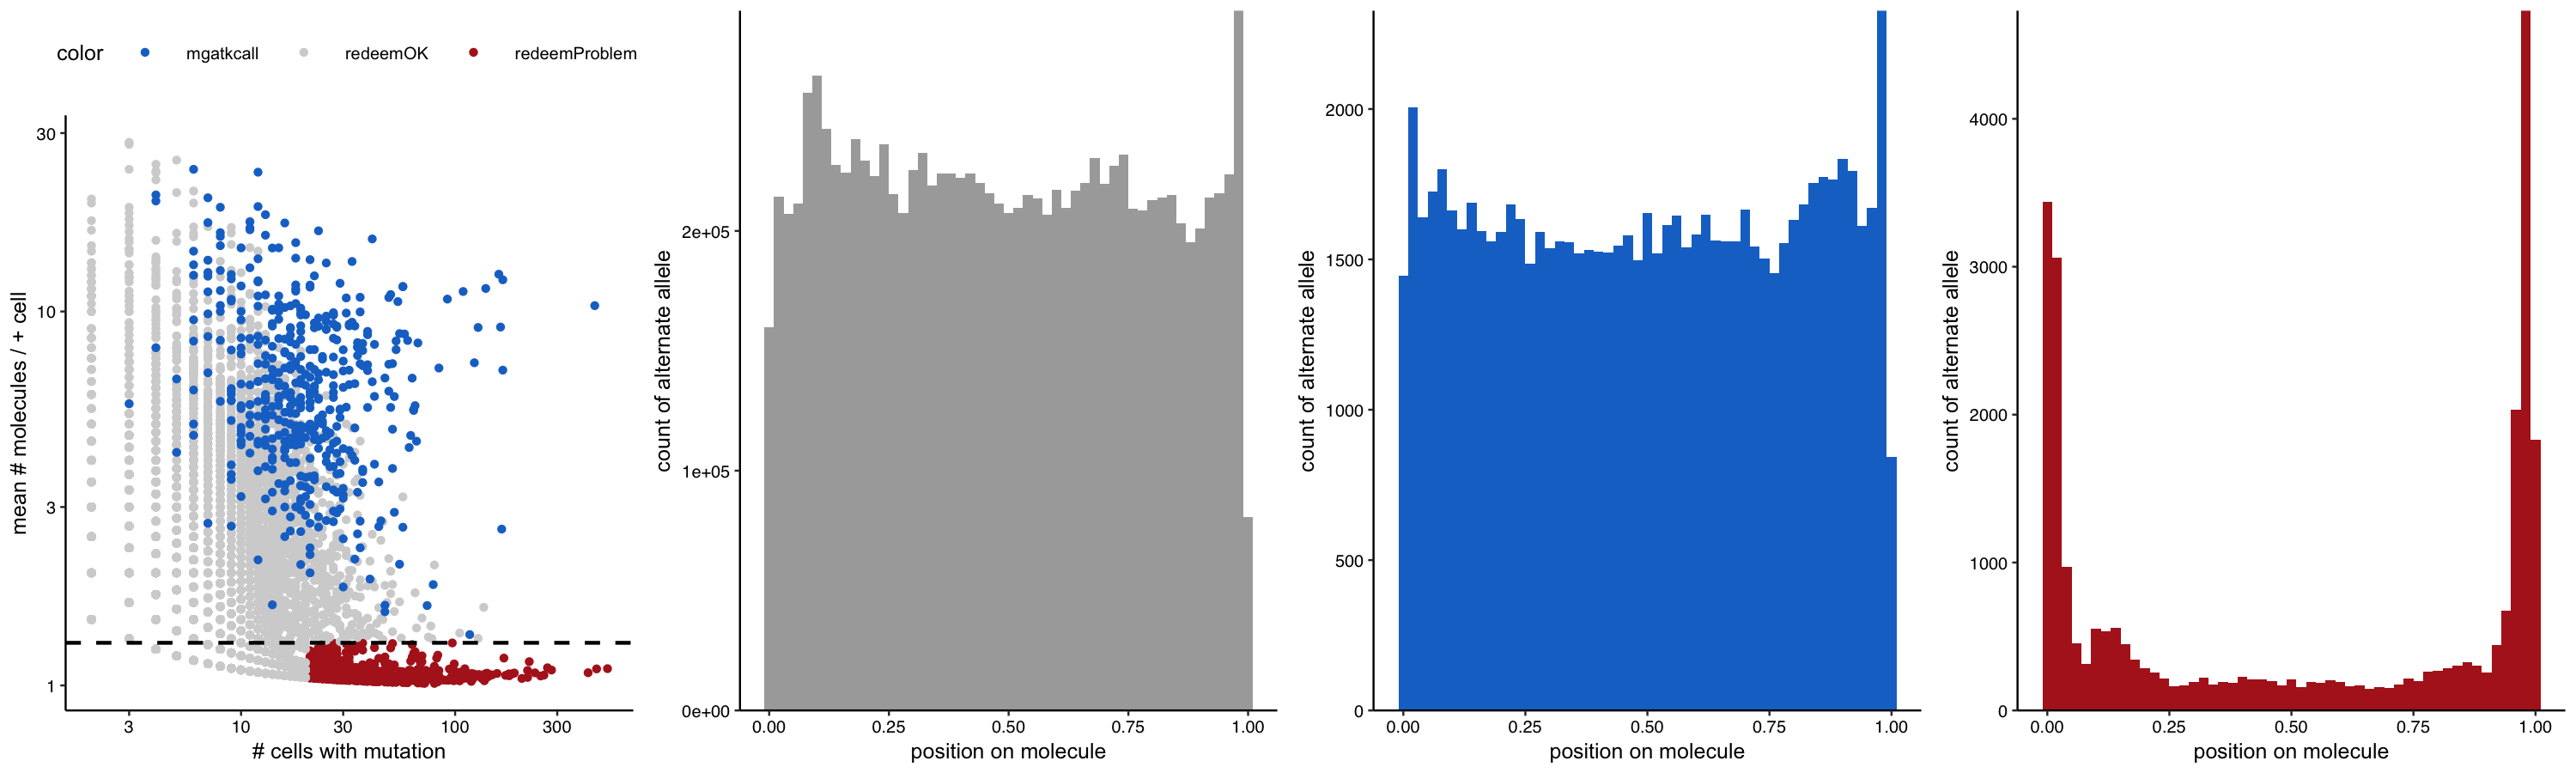

In [16]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 300)

cowplot::plot_grid(p1, p4, p3, p2, nrow = 1)

In [10]:

#cowplot::ggsave2(cowplot::plot_grid(p1, p4, p3, p2, nrow = 1), 
#                 width = 5.5, height = 1.1, file = paste0("../final_plots/", sample_id, "_plots.pdf"))

# Pull data out
get_edgeFC <- function(ggploto){
    df <-  ggplot_build(ggploto)$data[[1]]
    mean(df[c(1:3, 49,50,51),"y"])/mean(df[c(4:48),"y"])
}
get_edge_perc <- function(ggploto){
    df <-  ggplot_build(ggploto)$data[[1]]
    sum(df[c(1:3, 49,50,51),"y"])/sum(df[,"y"])*100
}

data.frame(
    what = c("mgatk", "homoplasmic", "redeem_low"),
    value = round(c(get_edgeFC(p3), get_edgeFC(p4), get_edgeFC(p2)), 2),
    percent_edge = round(c(get_edge_perc(p3), get_edge_perc(p4), get_edge_perc(p2)), 2)
)

what,value,percent_edge
<chr>,<dbl>,<dbl>
mgatk,1.03,12.06
homoplasmic,0.89,10.62
redeem_low,10.10,57.38
